In [1]:
import pandas as pd
import numpy as np
import calendar
import itertools


from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf, pacf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
como = pd.read_csv('Project - 3 - India_Key_Commodities_Retail_Prices_1997_2015.csv')
como.head()

,Date,Centre,Commodity,Price per Kg,Region,Country
0,25-11-1997,LUCKNOW,Tur/Arhar Dal,15.0,NORTH,INDIA
1,25-11-1997,BHOPAL,Tur/Arhar Dal,18.0,WEST,INDIA
2,25-11-1997,JAIPUR,Tur/Arhar Dal,20.0,WEST,INDIA
3,25-11-1997,SHIMLA,Tur/Arhar Dal,21.5,NORTH,INDIA
4,25-11-1997,AHMEDABAD,Tur/Arhar Dal,21.5,WEST,INDIA


In [3]:
como.shape

(846672, 6)

In [4]:
date = [pd.datetime.strptime(d,'%d-%m-%Y') for d in como.Date]
como['Timeindex'] = date
como.head()

,Date,Centre,Commodity,Price per Kg,Region,Country,Timeindex
0,25-11-1997,LUCKNOW,Tur/Arhar Dal,15.0,NORTH,INDIA,1997-11-25
1,25-11-1997,BHOPAL,Tur/Arhar Dal,18.0,WEST,INDIA,1997-11-25
2,25-11-1997,JAIPUR,Tur/Arhar Dal,20.0,WEST,INDIA,1997-11-25
3,25-11-1997,SHIMLA,Tur/Arhar Dal,21.5,NORTH,INDIA,1997-11-25
4,25-11-1997,AHMEDABAD,Tur/Arhar Dal,21.5,WEST,INDIA,1997-11-25


In [5]:
como['Month-year'] = como.Timeindex.dt.to_period('M')
como.head()

,Date,Centre,Commodity,Price per Kg,Region,Country,Timeindex,Month-year
0,25-11-1997,LUCKNOW,Tur/Arhar Dal,15.0,NORTH,INDIA,1997-11-25,1997-11
1,25-11-1997,BHOPAL,Tur/Arhar Dal,18.0,WEST,INDIA,1997-11-25,1997-11
2,25-11-1997,JAIPUR,Tur/Arhar Dal,20.0,WEST,INDIA,1997-11-25,1997-11
3,25-11-1997,SHIMLA,Tur/Arhar Dal,21.5,NORTH,INDIA,1997-11-25,1997-11
4,25-11-1997,AHMEDABAD,Tur/Arhar Dal,21.5,WEST,INDIA,1997-11-25,1997-11


In [6]:
north = como[(como.Region == 'NORTH')]

In [7]:
north.head()

,Date,Centre,Commodity,Price per Kg,Region,Country,Timeindex,Month-year
0,25-11-1997,LUCKNOW,Tur/Arhar Dal,15.0,NORTH,INDIA,1997-11-25,1997-11
3,25-11-1997,SHIMLA,Tur/Arhar Dal,21.5,NORTH,INDIA,1997-11-25,1997-11
5,25-11-1997,DELHI,Tur/Arhar Dal,22.0,NORTH,INDIA,1997-11-25,1997-11
16,26-11-1997,DELHI,Tur/Arhar Dal,22.0,NORTH,INDIA,1997-11-26,1997-11
17,26-11-1997,SHIMLA,Tur/Arhar Dal,21.5,NORTH,INDIA,1997-11-26,1997-11


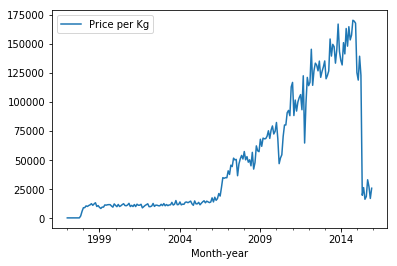

In [8]:
north.groupby('Month-year').sum().plot()
plt.show()

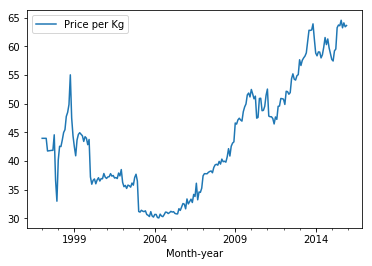

In [9]:
north.groupby('Month-year').mean().plot()
plt.show()

In [10]:
commodity = north.Commodity.unique()

Tur/Arhar Dal


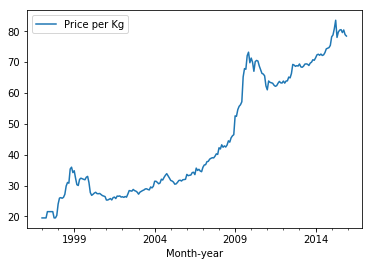

Tomato


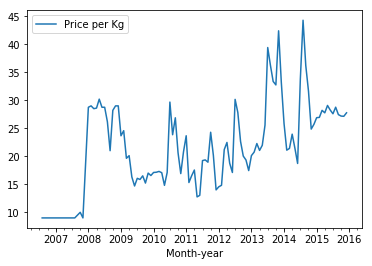

Tea Loose


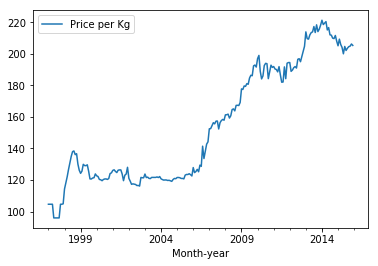

Sunflower Oil (Packed)


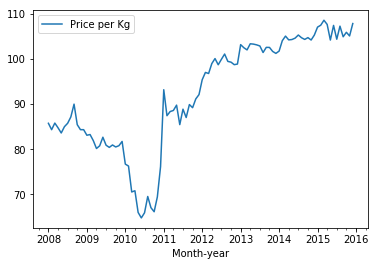

Sugar


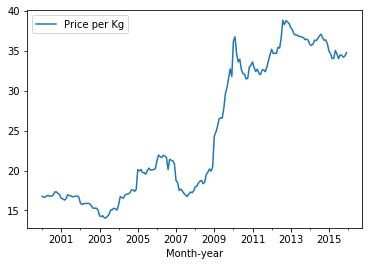

Salt Pack (Iodised)


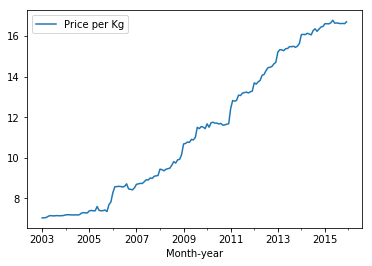

Onion


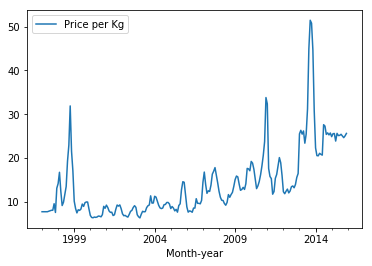

Milk


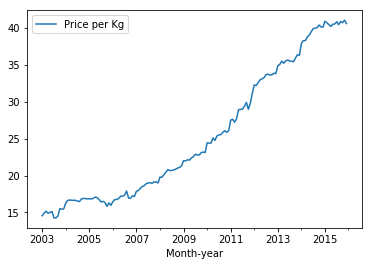

Rice


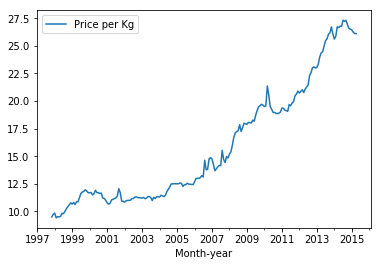

In [11]:
for i in commodity:
    print(i)
    north[north.Commodity == i].groupby('Month-year').mean().plot()
    plt.show()

# Tur/Arhar Dal Analysis in North region

## Feature Engineering

In [12]:
dal = north[north.Commodity == 'Rice']

In [13]:
dal= dal.groupby('Month-year').mean().reset_index()

In [14]:
dal.head()

,Month-year,Price per Kg
0,1997-11,9.500000
1,1997-12,9.742424
2,1998-01,9.847458
3,1998-02,9.412037
4,1998-03,9.527778


In [15]:
month=dal['Month-year'].dt.month
dal['Month'] = [calendar.month_abbr[i] for i in month]
dal['Year']=dal['Month-year'].dt.year

In [16]:
dal.head(5)

,Month-year,Price per Kg,Month,Year
0,1997-11,9.500000,Nov,1997
1,1997-12,9.742424,Dec,1997
2,1998-01,9.847458,Jan,1998
3,1998-02,9.412037,Feb,1998
4,1998-03,9.527778,Mar,1998


In [17]:
dal.tail()

,Month-year,Price per Kg,Month,Year
205,2014-12,26.516129,Dec,2014
206,2015-01,26.420118,Jan,2015
207,2015-02,26.239264,Feb,2015
208,2015-03,26.113821,Mar,2015
209,2015-04,26.095847,Apr,2015


In [18]:
len(dal)

210

## Missing Value Treatment

In [19]:
dal=dal.set_index('Month-year')
dal.head()

,Price per Kg,Month,Year
Month-year,,,
1997-11,9.500000,Nov,1997
1997-12,9.742424,Dec,1997
1998-01,9.847458,Jan,1998
1998-02,9.412037,Feb,1998
1998-03,9.527778,Mar,1998


In [20]:
dal=dal.reindex(pd.period_range(dal.index[0],dal.index[-1], freq='M'))
dal=dal.reset_index()
dal.head(12)

,index,Price per Kg,Month,Year
0,1997-11,9.500000,Nov,1997
1,1997-12,9.742424,Dec,1997
2,1998-01,9.847458,Jan,1998
3,1998-02,9.412037,Feb,1998
4,1998-03,9.527778,Mar,1998
5,1998-04,9.500000,Apr,1998
6,1998-05,9.552632,May,1998
7,1998-06,9.830303,Jun,1998
8,1998-07,9.788636,Jul,1998
9,1998-08,10.000000,Aug,1998


In [21]:
len(dal)

210

In [22]:
#date = pd.date_range(start='31-01-1997', end='31-12-2015',freq='M')

In [23]:
#newdal = pd.DataFrame({'Timeindex': date})

In [24]:
#newdal['Month-year'] = newdal.Timeindex.dt.to_period('M')
#newdal.head()

In [25]:
#dal = newdal.set_index('Month-year').join(dal.set_index('Month-year'))

In [26]:
#dal.reset_index(inplace=True)

In [27]:
dal.columns

Index(['index', 'Price per Kg', 'Month', 'Year'], dtype='object')

In [28]:
dal.columns = ['Month-year', 'Price per Kg', 'Month', 'Year']
dal.head(10)

,Month-year,Price per Kg,Month,Year
0,1997-11,9.500000,Nov,1997
1,1997-12,9.742424,Dec,1997
2,1998-01,9.847458,Jan,1998
3,1998-02,9.412037,Feb,1998
4,1998-03,9.527778,Mar,1998
5,1998-04,9.500000,Apr,1998
6,1998-05,9.552632,May,1998
7,1998-06,9.830303,Jun,1998
8,1998-07,9.788636,Jul,1998
9,1998-08,10.000000,Aug,1998


In [29]:
month=dal['Month-year'].dt.month
dal['Month'] = [calendar.month_abbr[i] for i in month]
dal['Year']=dal['Month-year'].dt.year

In [30]:
dal.head(12)

,Month-year,Price per Kg,Month,Year
0,1997-11,9.500000,Nov,1997
1,1997-12,9.742424,Dec,1997
2,1998-01,9.847458,Jan,1998
3,1998-02,9.412037,Feb,1998
4,1998-03,9.527778,Mar,1998
5,1998-04,9.500000,Apr,1998
6,1998-05,9.552632,May,1998
7,1998-06,9.830303,Jun,1998
8,1998-07,9.788636,Jul,1998
9,1998-08,10.000000,Aug,1998


In [31]:
dal.isnull().sum()

Month-year      0
Price per Kg    0
Month           0
Year            0
dtype: int64

In [32]:
np.mean(dal['Price per Kg'])

15.851889569879534

In [33]:
dal.head(12)

,Month-year,Price per Kg,Month,Year
0,1997-11,9.500000,Nov,1997
1,1997-12,9.742424,Dec,1997
2,1998-01,9.847458,Jan,1998
3,1998-02,9.412037,Feb,1998
4,1998-03,9.527778,Mar,1998
5,1998-04,9.500000,Apr,1998
6,1998-05,9.552632,May,1998
7,1998-06,9.830303,Jun,1998
8,1998-07,9.788636,Jul,1998
9,1998-08,10.000000,Aug,1998


In [34]:
dal.tail()

,Month-year,Price per Kg,Month,Year
205,2014-12,26.516129,Dec,2014
206,2015-01,26.420118,Jan,2015
207,2015-02,26.239264,Feb,2015
208,2015-03,26.113821,Mar,2015
209,2015-04,26.095847,Apr,2015


In [35]:
date = pd.date_range(start='11-30-1997', end='04-30-2015', freq='M')
dal['Timeindex'] = date

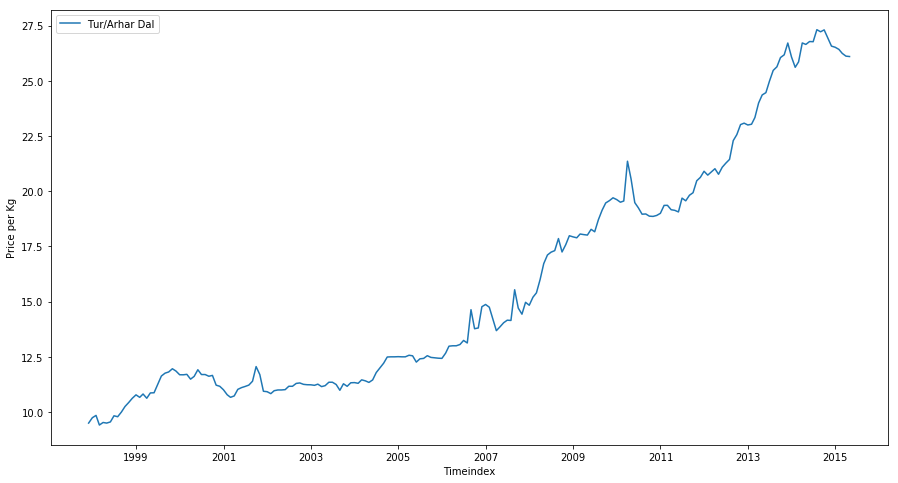

In [36]:
plt.figure(figsize=(15,8))
plt.plot(dal.Timeindex, dal['Price per Kg'], label='Tur/Arhar Dal')
plt.xlabel('Timeindex')
plt.ylabel('Price per Kg')
#plt.title('Onion Price')
plt.legend()
plt.show()

In [37]:
dal['Price per Kg'].interpolate(method='linear', inplace=True)

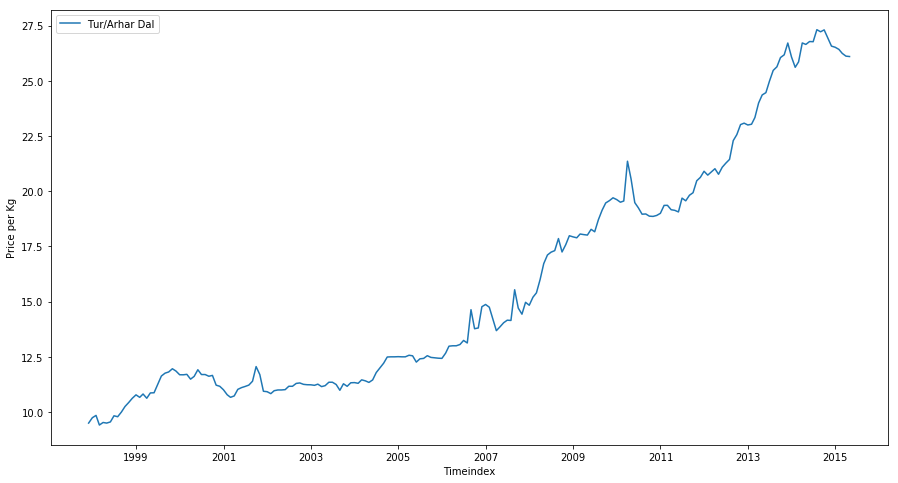

In [38]:
plt.figure(figsize=(15,8))
plt.plot(dal.Timeindex, dal['Price per Kg'],label='Tur/Arhar Dal')
plt.xlabel('Timeindex')
plt.ylabel('Price per Kg')
#plt.title('Onion Price')
plt.legend()
plt.show()

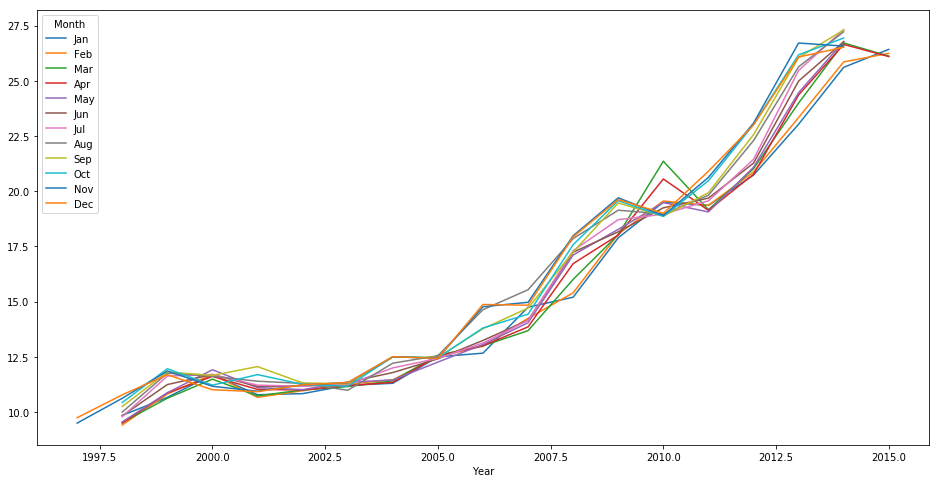

In [39]:
monthabb = [calendar.month_abbr[i] for i in range(1,13)]
pivottable=pd.pivot_table(dal,values='Price per Kg',columns='Month',index='Year')
pivottable=pivottable.reindex_axis(monthabb,axis=1)
pivottable.plot(figsize=(16,8))
plt.show()

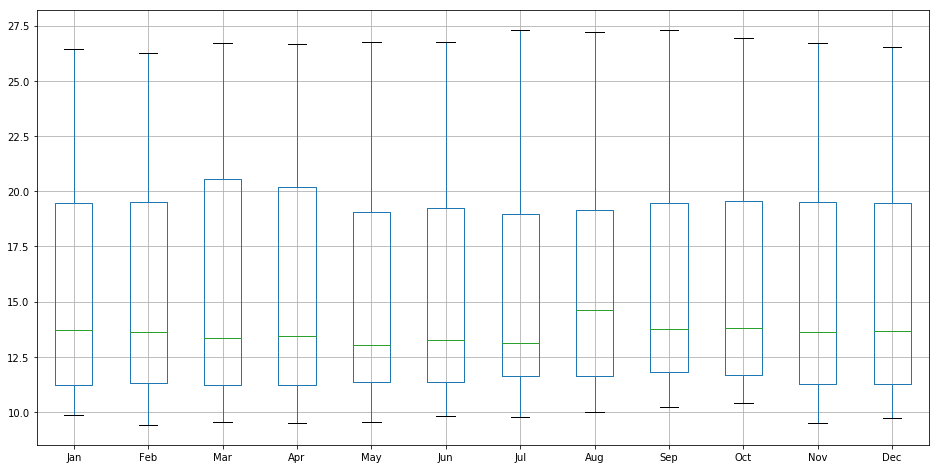

In [40]:
pivottable.boxplot(figsize=(16,8))
plt.show()

## Test-Train Split

In [41]:
train = dal.head(len(dal)-24)
test = dal.tail(24)

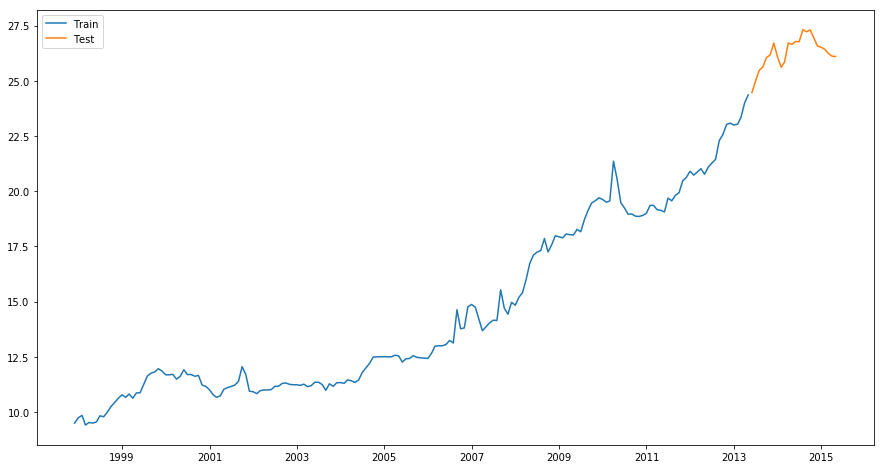

In [42]:
plt.figure(figsize=(15,8))
plt.plot(train.Timeindex, train['Price per Kg'], label = 'Train')
plt.plot(test.Timeindex, test['Price per Kg'], label= 'Test')
plt.savefig('train-test')
plt.legend()
plt.show()

## Define Evaluation Function

In [43]:
def mape(x,y):
    x,y = np.array(x), np.array(y)
    temp = np.mean(np.abs(x-y)/x)
    return round(temp*100,2)

## 1. Simple Exponential Model

In [44]:
model = SimpleExpSmoothing(np.asarray(train['Price per Kg']))

In [45]:
s=0
alpha=[]
for i in range(20):
    alpha.append(s)
    s= s+0.05

In [46]:
alpha_val =[]
mapeval =[]
for i in alpha:
    model_fit = model.fit(smoothing_level=i,optimized=False)
    fcst = model_fit.forecast(len(test['Price per Kg']))
    alpha_val.append(i)
    mapeval.append(mape(test['Price per Kg'], fcst))

In [47]:
a=pd.DataFrame({'alpha': alpha_val, 'MAPE': mapeval})
a=a.sort_values('MAPE').reset_index()
a.drop('index',axis=1, inplace=True)
a.iloc[0]

alpha    0.95
MAPE     7.31
Name: 0, dtype: float64

In [48]:
model_fit = model.fit(smoothing_level=0.95,optimized=False)
fcst = model_fit.forecast(len(test['Price per Kg']))
test['ForecastSE'] = fcst

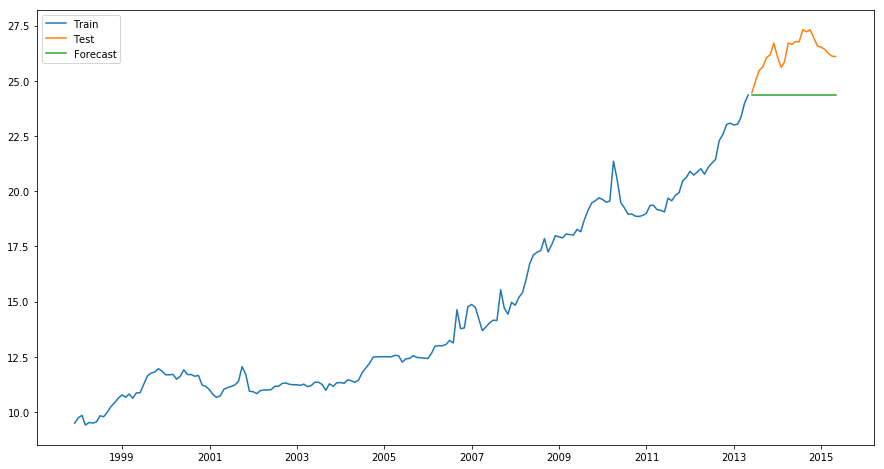

In [49]:
plt.figure(figsize=(15,8))
plt.plot(train.Timeindex, train['Price per Kg'], label = 'Train')
plt.plot(test.Timeindex, test['Price per Kg'], label= 'Test')
plt.plot(test.Timeindex, test['ForecastSE'], label= 'Forecast')
plt.legend()
plt.show()

In [50]:
print('The MAPE value for Simple Exponential is : ', mape(test['Price per Kg'],test['ForecastSE']))

The MAPE value for Simple Exponential is :  7.31


## 2. Double Exponential Model or Holt Linear Model

In [51]:
model = Holt(np.asarray(train['Price per Kg']))

In [52]:
s=0
alpha=[]
beta=[]
for i in range(20):
    alpha.append(s)
    beta.append(s)
    s= s+0.05

In [53]:
alpha_val = []
beta_val = []
mapeval = []
for i in alpha:
    for j in beta:
        model_fit = model.fit(smoothing_level=i, smoothing_slope=j, optimized=False)
        fcst = model_fit.forecast(len(test['Price per Kg']))
        alpha_val.append(i)
        beta_val.append(j)
        mapeval.append(mape(test['Price per Kg'], fcst))

In [54]:
a=pd.DataFrame({'alpha': alpha_val, 'beta': beta_val,'MAPE': mapeval})
a=a.sort_values('MAPE').reset_index()
a.drop('index',axis=1, inplace=True)
a.iloc[0]

alpha    0.05
beta     0.90
MAPE     2.80
Name: 0, dtype: float64

In [55]:
model_fit = model.fit(smoothing_level=0.05, smoothing_slope=0.90, optimized=False)
fcst = model_fit.forecast(len(test['Price per Kg']))
test['ForecastDE'] = fcst

In [56]:
model = Holt(np.asarray(dal['Price per Kg']))
model_fit = model.fit(smoothing_level=0.30, smoothing_slope=0.55, optimized=False)
fcst = model_fit.forecast(12)
daldf = pd.DataFrame(fcst)
daldf.to_csv('dalforecast.csv')

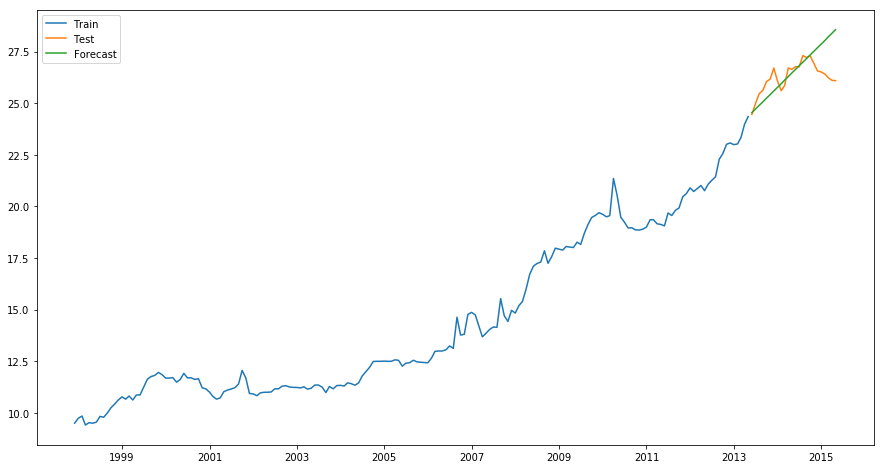

In [57]:
plt.figure(figsize=(15,8))
plt.plot(train.Timeindex, train['Price per Kg'], label = 'Train')
plt.plot(test.Timeindex, test['Price per Kg'], label= 'Test')
plt.plot(test.Timeindex, test['ForecastDE'], label= 'Forecast')
plt.legend()
plt.show()

In [58]:
print('The MAPE value for Double Exponential is : ', mape(test['Price per Kg'],test['ForecastDE']))

The MAPE value for Double Exponential is :  2.8


## 3. Holt-Winter Model

In [59]:
model = ExponentialSmoothing(np.asarray(train['Price per Kg']),seasonal_periods=12,seasonal='add')

In [60]:
s=0
alpha=[]
beta=[]
gamma=[]
for i in range(20):
    alpha.append(s)
    beta.append(s)
    gamma.append(s)
    s= s+0.05

In [61]:
alpha_val=[]
beta_val=[]
gamma_val=[]
mapeval=[]

for i in alpha:
    for j in beta:
        for k in gamma:
            model_fit=model.fit(smoothing_level=i, smoothing_slope=j, smoothing_seasonal=k, optimized=False)
            fcst = model_fit.forecast(len(test['Price per Kg']))
            alpha_val.append(i)
            beta_val.append(j)
            gamma_val.append(k)
            mapeval.append(mape(test['Price per Kg'], fcst))

In [62]:
a=pd.DataFrame({'alpha': alpha_val, 'beta': beta_val,'gamma': gamma_val, 'MAPE': mapeval})
a=a.sort_values('MAPE').reset_index()
a.drop('index',axis=1, inplace=True)
a.iloc[0]

alpha    0.90
beta     0.55
gamma    0.95
MAPE     5.52
Name: 0, dtype: float64

In [63]:
model_fit = model.fit(smoothing_level=0.90,smoothing_slope=0.55, smoothing_seasonal=0.95,optimized=False)
fcst = model_fit.forecast(len(test))
#fttval = model_fit.fittedvalues
test['ForecastHW'] = fcst

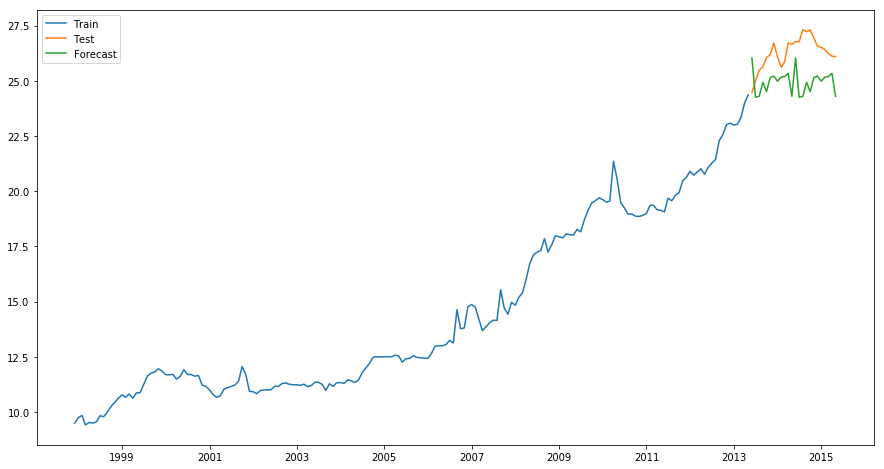

In [64]:
plt.figure(figsize=(15,8))
plt.plot(train.Timeindex, train['Price per Kg'], label = 'Train')
#plt.plot(train.Timeindex, fttval, label = 'Fitted Value')
plt.plot(test.Timeindex, test['Price per Kg'], label= 'Test')
plt.plot(test.Timeindex, test['ForecastHW'], label= 'Forecast')
plt.legend()
plt.show()

In [65]:
print('The MAPE value for Holt-Winters Model is : ', mape(test['Price per Kg'],test['ForecastHW']))

The MAPE value for Holt-Winters Model is :  5.52


In [66]:
model = ExponentialSmoothing(np.asarray(dal['Price per Kg']),seasonal_periods=12,seasonal='add')
model_fit = model.fit(smoothing_level=0.95,smoothing_slope=0.6, smoothing_seasonal=0.9,optimized=False)
fcst = model_fit.forecast(12)
daldf = pd.DataFrame(fcst)
daldf.to_csv('dalforecast.csv')

## 4. ARIMA Model

### Stationarizing the series

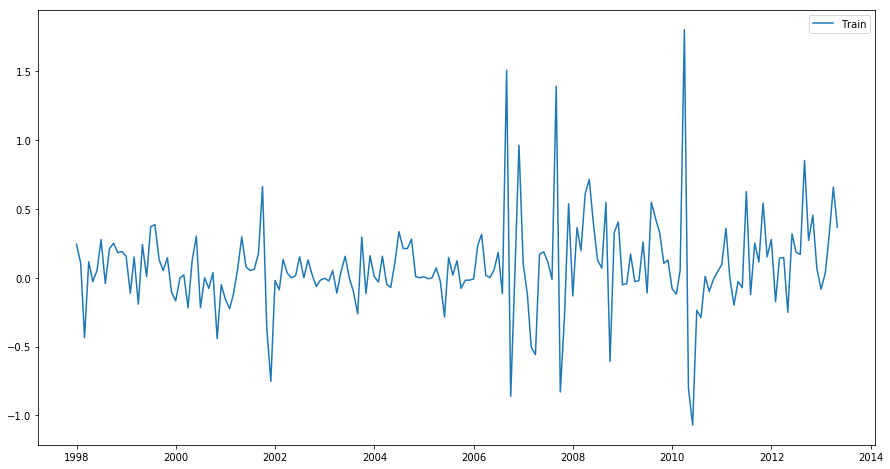

In [67]:
plt.figure(figsize=(15,8))
plt.plot(train.Timeindex, train['Price per Kg'].diff(periods=1), label = 'Train')
plt.legend()
plt.show()

In [68]:
price_station = train['Price per Kg'].diff(periods=1)
price_station.dropna(inplace=True)
stattest = adfuller(price_station)
stattest

(-14.240928614581007,
 1.5381629089989773e-26,
 0,
 184,
 {'1%': -3.466398230774071,
  '5%': -2.8773796387256514,
  '10%': -2.575213838610586},
 129.51529993058278)

In [69]:
lag_acf=acf(price_station, nlags=20)
lag_pacf = pacf(price_station, nlags=20)

In [70]:
lag_acf

array([ 1.00000000e+00, -5.51380338e-02, -8.63611083e-02,  8.30377208e-02,
       -4.40850910e-02,  1.50477470e-02,  7.66606630e-04,  5.13638101e-03,
        1.18037217e-02,  8.84216495e-02,  2.07816602e-02, -7.85238048e-02,
        1.81263608e-01, -1.78427397e-01, -7.58272088e-02,  7.40322995e-02,
        4.28935422e-02,  4.82685758e-02, -9.40433329e-02,  9.07641810e-02,
        1.94233213e-02])

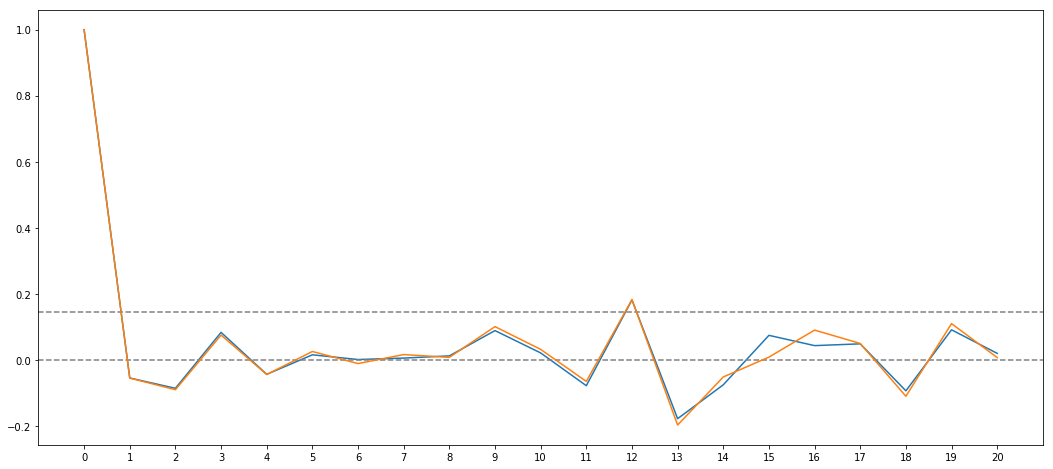

In [71]:
plt.figure(figsize=(18,8))
plt.plot(lag_acf)
plt.axhline(0, linestyle = '--', color='grey')
plt.axhline(1.96/np.sqrt(len(price_station)), linestyle = '--', color='grey')
plt.plot(lag_pacf)
plt.xticks(range(0,21))
plt.show()

We can infer from fuller test that the series is stationary

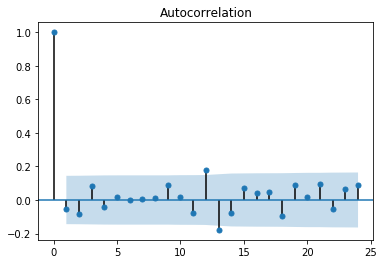

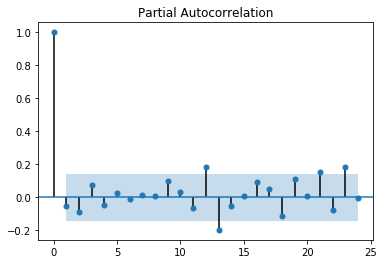

In [72]:
smt.graphics.plot_acf(price_station, lags=24)
smt.graphics.plot_pacf(price_station, lags=24)
plt.show()

From partial correlation, ignore the 0 lag and then check significatn spikes in timeseries, there are two spikes so we will take AR(2) for the model. Also the cutoff in Auto-corelation graph is at 0 lag, so the best model will habe MA(0). Difference we already know is 1. So with this information we can do ARIMA(2,1,0) model for the dataset.

We will also check AIC to get best parameters

In [73]:
p=d=q=range(0,3)

In [74]:
pdq = list(itertools.product(p,d,q))

In [75]:
aic_val=[]
pdq_val=[]
for i in pdq:
    try:
        model = ARIMA(train['Price per Kg'], order= i)
        model_fit = model.fit()
        aic_val.append(model_fit.aic)
        pdq_val.append(i)
    except:
        continue

In [76]:
a= pd.DataFrame({'pdq': pdq_val, 'AIC': aic_val})
a.sort_values('AIC', inplace=True)
a.iloc[0]

pdq    (0, 1, 0)
AIC      129.673
Name: 3, dtype: object

In [77]:
model = ARIMA(train['Price per Kg'], order= (0,1,0))
model_fit = model.fit()
fcst=model_fit.forecast(steps=24)[0]
test['ForecastAR'] = fcst

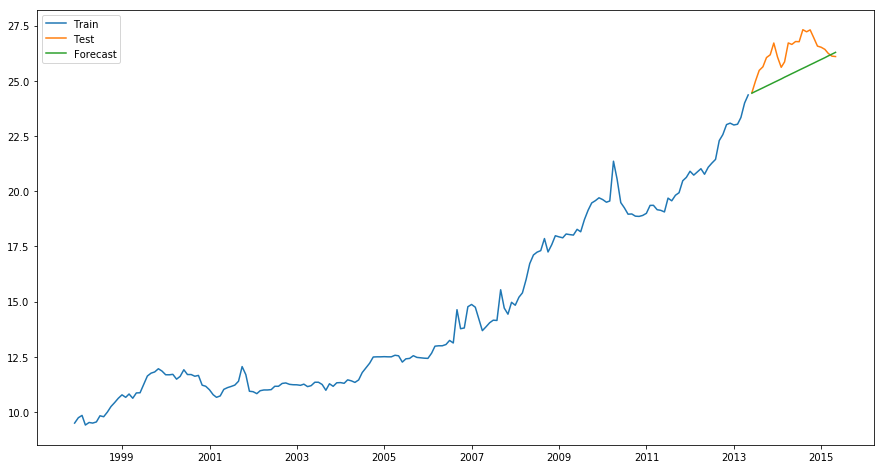

In [78]:
plt.figure(figsize=(15,8))
plt.plot(train.Timeindex, train['Price per Kg'], label = 'Train')
plt.plot(test.Timeindex, test['Price per Kg'], label= 'Test')
plt.plot(test.Timeindex, test['ForecastAR'], label= 'Forecast')
plt.legend()
plt.show()

In [79]:
print('The MAPE value for ARIMA Model is : ', mape(test['Price per Kg'],test['ForecastAR']))

The MAPE value for ARIMA Model is :  3.54


## 5. Seasonal ARIMA

In [80]:
p=d=q=range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in pdq]

In [81]:
aic_val = []
pdq_val = []
spdq_val = []

for i in pdq:
    for j in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train['Price per Kg'], order=i,seasonal_order=j,enforce_stationarity=True)
            model_fit = model.fit()
            aic_val.append(model_fit.aic)
            pdq_val.append(i)
            spdq_val.append(j)
        except:
            continue


In [82]:
a= pd.DataFrame({'pdq': pdq_val, 'spdq': spdq_val, 'AIC': aic_val})
a.sort_values('AIC', inplace=True)
a.iloc[0]

pdq         (0, 1, 0)
spdq    (1, 0, 0, 12)
AIC           130.907
Name: 10, dtype: object

In [83]:
model = sm.tsa.statespace.SARIMAX(train['Price per Kg'], order=(0,1,0),seasonal_order=(1,0,0,12),enforce_stationarity=True)
model_fit = model.fit()
fcst=model_fit.forecast(steps=24)
test['ForecastSAR'] = fcst

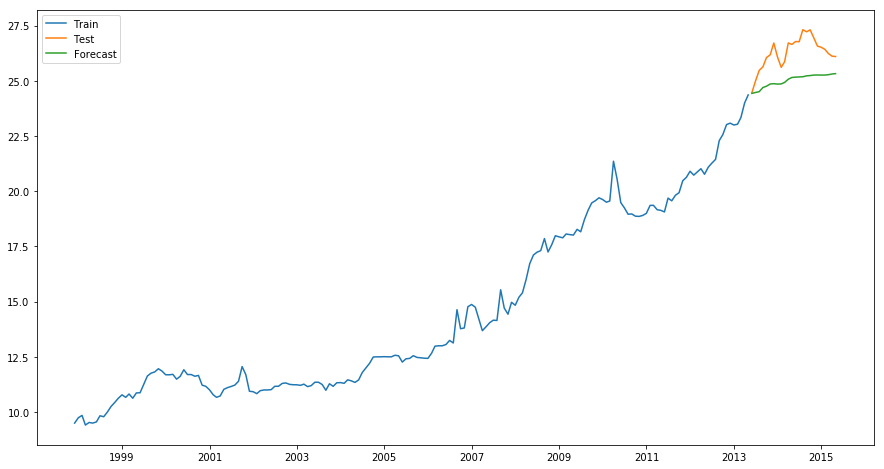

In [84]:
plt.figure(figsize=(15,8))
plt.plot(train.Timeindex, train['Price per Kg'], label = 'Train')
plt.plot(test.Timeindex, test['Price per Kg'], label= 'Test')
plt.plot(test.Timeindex, test['ForecastSAR'], label= 'Forecast')
plt.legend()
plt.show()

In [85]:
print('The MAPE value for Seasonal ARIMA Model is : ', mape(test['Price per Kg'],test['ForecastSAR']))

The MAPE value for Seasonal ARIMA Model is :  4.76


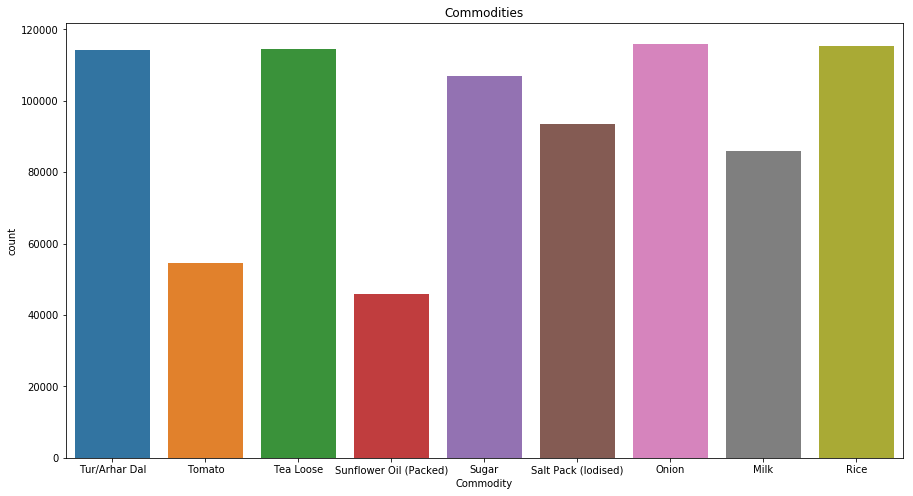

In [86]:
plt.figure(figsize=(15,8))
sns.countplot(x='Commodity', data=como)
plt.title('Commodities')
plt.show()

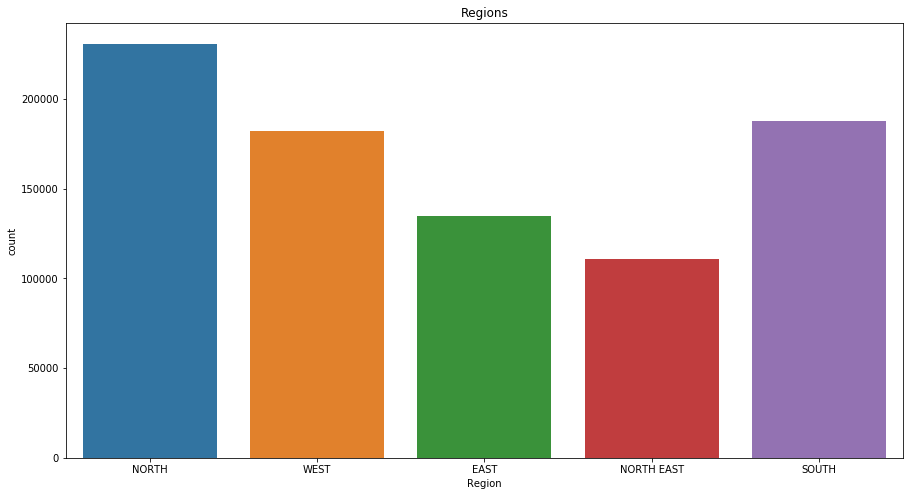

In [87]:
plt.figure(figsize=(15,8))
sns.countplot(x='Region', data=como)
plt.title('Regions')
plt.show()

In [88]:
dal.head()

,Month-year,Price per Kg,Month,Year,Timeindex
0,1997-01,19.500000,Jan,1997,1997-01-31
1,1997-02,19.500000,Feb,1997,1997-02-28
2,1997-03,19.500000,Mar,1997,1997-03-31
3,1997-04,19.500000,Apr,1997,1997-04-30
4,1997-05,21.533333,May,1997,1997-05-31


In [89]:
como.head()

,Date,Centre,Commodity,Price per Kg,Region,Country,Timeindex,Month-year
0,25-11-1997,LUCKNOW,Tur/Arhar Dal,15.0,NORTH,INDIA,1997-11-25,1997-11
1,25-11-1997,BHOPAL,Tur/Arhar Dal,18.0,WEST,INDIA,1997-11-25,1997-11
2,25-11-1997,JAIPUR,Tur/Arhar Dal,20.0,WEST,INDIA,1997-11-25,1997-11
3,25-11-1997,SHIMLA,Tur/Arhar Dal,21.5,NORTH,INDIA,1997-11-25,1997-11
4,25-11-1997,AHMEDABAD,Tur/Arhar Dal,21.5,WEST,INDIA,1997-11-25,1997-11


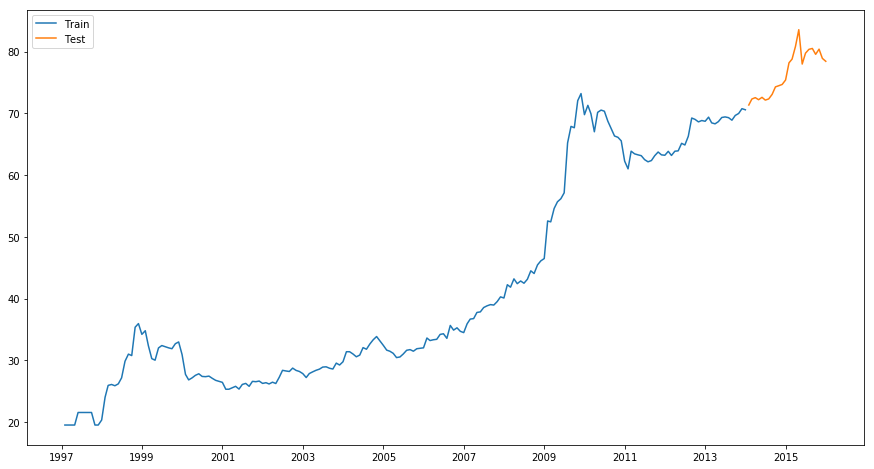

In [90]:
plt.figure(figsize=(15,8))
plt.plot(train.Timeindex, train['Price per Kg'], label = 'Train')
plt.plot(test.Timeindex, test['Price per Kg'], label= 'Test')
plt.savefig('train-test')
plt.legend()
plt.show()

In [91]:
test

,Month-year,Price per Kg,Month,Year,Timeindex,ForecastSE,ForecastDE,ForecastHW,ForecastAR,ForecastSAR
204,2014-01,71.361011,Jan,2014,2014-01-31,70.596021,70.933011,72.712706,70.686162,71.474806
205,2014-02,72.330882,Feb,2014,2014-02-28,70.596021,71.378037,70.268664,71.013282,71.392117
206,2014-03,72.555195,Mar,2014,2014-03-31,70.596021,71.823063,69.552974,71.226119,71.354696
207,2014-04,72.221053,Apr,2014,2014-04-30,70.596021,72.268089,75.987165,71.495729,71.581785
208,2014-05,72.604230,May,2014,2014-05-31,70.596021,72.713116,74.500410,71.737135,72.147887
209,2014-06,72.155709,Jun,2014,2014-06-30,70.596021,73.158142,73.550339,71.992553,72.456721
210,2014-07,72.346875,Jul,2014,2014-07-31,70.596021,73.603168,75.834269,72.241009,73.076298
211,2014-08,73.087108,Aug,2014,2014-08-31,70.596021,74.048194,75.366781,72.492924,73.610384
212,2014-09,74.298013,Sep,2014,2014-09-30,70.596021,74.493220,76.020665,72.743121,73.584716
213,2014-10,74.492625,Oct,2014,2014-10-31,70.596021,74.938246,74.700189,72.994171,74.262961


In [86]:
def rmse_val(par1, par2):
    val = np.sqrt(np.mean(np.square(par1-par2)))
    return val

ac = test['Price per Kg']
se = test['ForecastSE']
de = test['ForecastDE']
hw = test['ForecastHW']
ar = test['ForecastAR']
sr = test['ForecastSAR']

print('SE: ', rmse_val(ac,se))
print('DE: ', rmse_val(ac,de))
print('HW: ', rmse_val(ac,hw))
print('AR: ', rmse_val(ac,ar))
print('SR: ', rmse_val(ac,sr))

SE:  2.057858608095702
DE:  1.0210906235889958
HW:  1.6160417709553327
AR:  1.0835978428236879
SR:  1.3595594099171624


SE:  6.875251391673988
DE:  1.8145125042954247
HW:  4.936285040365365
AR:  3.6209371544951017
SR:  3.18249734419489
